# Iteration

This notebook is intended to provide a introduction to the idea of iteration as a tool for addressing problems in physics and engineering that have no simple analytic or closed form solution. Almost every significant computational problem I have addressed in my learning has involved some form of an iterative model. 

There are a lot of descriptions of iteration as a computational technique out there but this [mathematical definition](https://www2.edc.org/makingmath/mathtools/iteration/iteration.asp) fits best with my experience. The previous link has some lovely examples from mathematics including the Mandlebrot set.

<blockquote> Iteration is the repeated application of a function or process in which the output of each step is used as the input for the next iteration. </blockquote>

#### Note about Jupyterlab toolbar issue:

There is a toolbar issue for some users in Jupyterlab where the cell type dropdown menu in the tool bar above doesn't allow me to select the cell type. It acts like I've double clicked my mouse or something. After trying to resolve this with various updates I am currently using keyboard methods to set the cell type. This [keyboard guide for Jupyterlab](https://nocomplexity.com/documents/jupyterlab/keyboardshortcuts.html) was very helpful.

## Periodic Motion with Drag: 

For the lab I have asked you to work with air drag in projectile motion. In this example I will explore finding a numerical solution to our damped periodic motion differential equation. The thought process is the same just in a different context.

Here is the differential equation:

$$ \large \frac{d^2x}{dt^2} + \frac{D}{m}\frac{dx}{dt} + \frac{k}{m} x = 0 $$

The Newtonian analysis that we used to arrive at this equation was based on an ideal spring and a model for drag forces in the air. Those models are (magnitude only):

$$ \large F_{spring} = k x$$

$$ \large F_{air \; drag} = D v = D \frac{dx}{dt}$$

Such a system is started by pulling the spring back to some initial location ($x_0$) and releasing it from rest ($v=0$). 

## Formal Solution:

The differential equation above has an analytic solution given by:

$$ \large x(t) = C e^{-bt} cos(\omega t + \phi)$$

..where...

$$\large b = \frac{D}{2m}$$

$$\large \omega = \sqrt{\frac{k}{m} - \frac{D^2}{4m^2}}$$

Knowing that there is a formal solution allows us to explore how an interative numerical solution compares to the analytic solution.

### Setup/Dependencies

These are the libraries and setups that I am using in this notebook

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Initial Conditions and Constants

In this differential equation the initial conditions are given previously and depend only on 3 factors which are D, k, and m. These are the constraints on our solution. I am going to assume no phase shift $\phi$.

### Iteration Constants

One way to set up an interation is to choose the total length of time you want to explore and the number of incremental steps in that interval. One can also choose length of each iterative step and the number of steps which gets you the same place by a different path.

### Sample System:

The damped periodic system that stimulated this discussion is the one shown in the [Damped and Driven breadcumb](http://coccweb.cocc.edu/bemerson/PhysicsGlobal/Courses/PH213/PH213Materials/PH213Breadcrumbs/PH213BCDampDrive.html). It has an initial x position of 1., a decay constant of 1., an $\omega_0 =10$, and a damped period of 0.632 s. This is equivalent to a damped angular frequency given by:

$$ f_{damped} = \frac{1}{T} = 1.5823 Hz$$

$$ \omega_{damped} = 2 \pi f = 9.942$$

Matching this system feels like a good way to test this iterative model.

I found it took a little fooling with the constants to get $\gamma = 1.$ and $\omega_0 = 10$ It is important to note that my $b$ is their $\gamma$

In [2]:
# initial conditions
initialVelocity = 0.0 # in m/s
initialPosition = 1. # in m

# constants
dragCoef = .22 # D is the drag coefficient
springConst = 11.   # the spring constant
massObject = .11 # mass in kg
decayConst = dragCoef/(2*massObject) # b in exponential term
naturalFreq = np.sqrt(springConst/massObject) # omega_0
dampedFreq = np.sqrt(naturalFreq**2 - (dragCoef**2/(4.*massObject**2)))

# initial condition for velocity when v_0 = 0!! only!!
phaseShift = np.arctan(-decayConst/dampedFreq)
amplitude = initialPosition/np.cos(phaseShift)

# interation constants
maxTime = 2.0 # in s
numPoints = 5000 # number data points in the array

print("Initial Velocity: %.2f m/s; Initial Position: %.2f m" % (initialVelocity,initialPosition))
print("Drag Coef: %.2f ; Spring Constant %.2f ; mass %.2f" % (dragCoef, springConst, massObject))
print("decay const: %.4f ; natural freq %.4f ; damped freq %.4f" % (decayConst, naturalFreq, dampedFreq))
print("phase shift: %.4f rad; amplitude (C) %.4f m" % (phaseShift,amplitude))


Initial Velocity: 0.00 m/s; Initial Position: 1.00 m
Drag Coef: 0.22 ; Spring Constant 11.00 ; mass 0.11
decay const: 1.0000 ; natural freq 10.0000 ; damped freq 9.9499
phase shift: -0.1002 rad; amplitude (C) 1.0050 m


## Analytic solution for Comparison:

First we create a set of times that we will use to calculate the x position of the mass using the [np.linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) function. Then apply the equations stated above. When we use the form of the analytic solution given above with no phase shift then C is the initial position.

From a code writing perspective I first verified that I could get the exponential part of this to plot the way I wanted and then I added in the periodic behavior.

```
xenvelope = initialPosition*np.exp(-decayConst*modelTime)
```

Then...

```
xposition = initialPosition*np.exp(-decayConst*modelTime)*np.cos(dampedFreq*modelTime)
```

I had to play with this a bit to be confident that the plot was showing what I wanted it to. This raises an important point which is that at every step in a model we have to look and think whether what we see in the plot is what we 'expect' or is correct. One of the beauties of a notebook is that I can go change various parameters all over the map and see what happens. Feel free to explore yourself.

### First Errors:

**#1 Amplitude:** My first overly casual assumption was that I could take the phase shift $\phi$ to be 0. Generally all the phase shift does is move the solution left and right but in this case it's a little more complex. Consider our analytic solution at t=0:

$$ \large x\rvert_{t=0} = C e^{0}cos(0 + \phi) = 1.0 m $$

$$ \large \implies C = \frac{x_0}{cos(\phi)}\; \therefore C\ne x_0 $$

**#2 Phase Shift:** This got me wondering how to find $\phi$. So I differentiated $x(t)$ to get a velocity expression and then set $t=0$.

$$\large \frac{dx}{dt} = Ce^{-bt}[-b cos(\omega t + \phi) -\omega sin(\omega t + \phi)]$$

It does NOT help that the first time I did this I lost the minus sign on the derivative of the cosine. Sheesh! Plugging in $t=0$ we get:

$$\large v\rvert_{t=0} = 0  = Ce^{0}[-b cos(\phi) -\omega sin(\phi)]$$

The term in the square brackets must be 0 which after a little algebra gives us:

$$ \large tan(\phi) = -\frac{b}{\omega} $$

## <span style = "color:red">Learning Task:</span>

In the previous errors I first lost a minus sign during my differentiation. Change the sign of $\phi$ in the previous code cell (above) and see if you can see the difference in the plot. Change...

```phaseShift = np.arctan(-decayConst/dampedFreq)```

to 

```phaseShift = np.arctan(decayConst/dampedFreq)```

Look carefully at the very beginning of the plot and think about slopes...This inconsistency in my plot kept bothering me until I found these errors. What is that inconsistency?

In [3]:
modelTime = np.linspace(0.,maxTime,numPoints)
xposition = amplitude*np.exp(-decayConst*modelTime)*np.cos(dampedFreq*modelTime+phaseShift)
xenvelope = initialPosition*np.exp(-decayConst*modelTime)

# analytic description of velocity if desired
xvelocity = amplitude*np.exp(-decayConst*modelTime)*(
    -decayConst*np.cos(dampedFreq*modelTime+phaseShift) -
    dampedFreq*np.sin(dampedFreq*modelTime+phaseShift))

# modelTime

## Plot

Now we plot it....

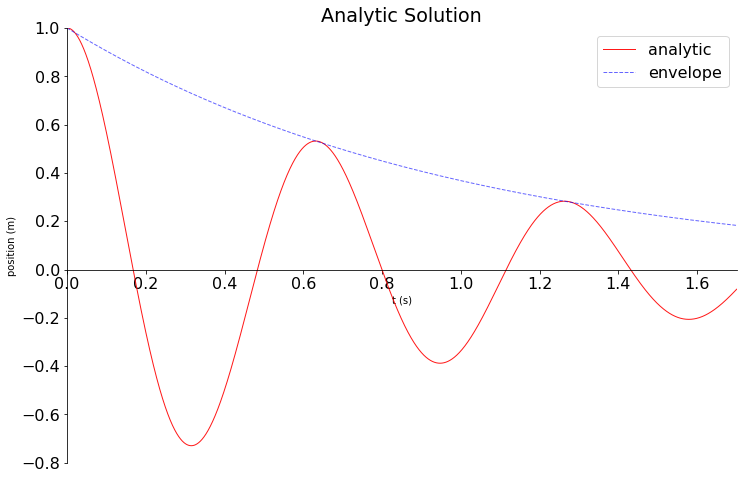

In [4]:
fig1, ax1 = plt.subplots()
ax1.plot(modelTime, xposition,
         color = 'red', linestyle = '-',alpha = 0.9,
         linewidth = 1., label = "analytic")
ax1.plot(modelTime, xenvelope,
         color = 'blue', linestyle = '--',alpha = 0.6,
         linewidth = 1., label = "envelope")


plt.rcParams.update({'font.size': 16}) # make labels easier to read
ax1.set(xlabel='t (s)', ylabel='position (m)',
       title='Analytic Solution')

# set axes through 0,0
ax1.spines['left'].set_position(('data', 0))
ax1.spines['bottom'].set_position(('data', 0))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


plt.xlim([0., 1.7])
plt.ylim([-.8, 1.0])
fig1.set_size_inches(12, 8)
plt.legend(loc= 1)

plt.show()

## Now the iterative numerical solution. 

Notice in the DE that if I know the position of the object initially I know what the spring force is. If I know velocity I also know the drag force. Here is the mental sequence....

* known: x and $v_0=0$ -- I can determine a
* knowing a and v I can predict where the object will be a little later AND it's velocity after a short time
* now I have a new position and velocity - determine a new a
* knowing the new a and v I can once again predict the new position and velocity a moment later...
* rinse and repeat...
$$ \large \bar{F}_{net} = \bar{F}_{spring} + \bar{F}_{drag} $$

### Next Errors:

**Algebra:** The first two steps in the iterative process come directly from our work in PH211 under the assumption that if we consider a short enough $\Delta t$ then the acceleration can be considered constant. In that case our normal kinematic tools apply. The following two lines of code are the same as the physics equations we derived from graphs.

```
    xPos[i] = xPos[i-1] + xVel[i-1]*deltaTime + 0.5*xAccel[i-1]*deltaTime**2
    xVel[i] = xVel[i-1] + xAccel[i-1]*deltaTime
```

$$ \large x_f = x_0 + v_0 \Delta t + \frac{1}{2} a_{cnst} (\Delta t)^2 $$ and

$$ \large v_f = v_0 + a_{cnst} \Delta t $$

Once the next position and velocity are known then I can calculate, from Newton's Law and my freebody diagram, the acceleration in the next moment. 

$$ \large \bar{F}_{net} = \bar{F}_{spring} + \bar{F}_{drag} = - kx - D\frac{dx}{dt} $$

$$ \large \implies a = \frac{-kx - D\frac{dx}{dt}}{m}  $$

When I was working on this part I was thinking about how this system is started by pulling the spring back and then releasing it from rest. As it first starts moving the acceleration created by the spring will be 'inward' (-) and the acceleration created by the drag force will be 'outward' (+). This led me to define the acceleration with a '+' sign between the terms. When I looked at the output of the model it seemed apparent there was a problem. This is what you will explore in the next **Learning Task**.

## <span style = "color:red">Learning Task:</span>

In the previous errors I first lost a minus sign during my differentiation. Change the sign of $\phi$ in the previous code cell (above) and see if you can see the difference in the plot. Change...

```xAccel[i] = -springConst*xPos[i]/massObject - dragCoef*xVel[i]/massObject```

to 

```xAccel[i] = -springConst*xPos[i]/massObject + dragCoef*xVel[i]/massObject```

A couple of cells down in the debugging cell uncomment the following lines so you can actually look at the data being generated. These statements print out the first 10 or so positions, velocities, and accelerations. 

```
print("analytic position: ",xposition[0:nData])
print("interative position: ",xPos[0:nData])
print("interative velocity: ",xVel[0:nData])
print("interative acceleration: ",xAccel[0:nData])
```
You will also need to increase the y limits of the plot in the plotting cell to be able to see the data. 

```
plt.ylim([-.8, 1.]) -> plt.ylim([-5., 5.])
```

Look at both the plot and the first 10 data points and describe what you notice about each. Particularly in the data points it should be clear what is going wrong. Change the sign between the acceleration terms back to a '-' and look at the data again. Make sense now?

Before you leave this task comment out the print statements since they are not needed any more and put the plot limits back to where there were.

In [5]:
itertime = maxTime # in s
iterpoints = numPoints # same number of points as analytic soln
iterationTime = np.linspace(0.,itertime,iterpoints)
deltaTime = iterationTime[1]-iterationTime[0] # determines the size of the delta t between points

# create the x(t) and y(t) arrays to be like iterationTime and fill with 0's
xPos = np.full_like(iterationTime,0)
xVel = np.full_like(iterationTime,0)
xAccel = np.full_like(iterationTime,0)

# set the first point of array to initial position and velocity
xPos[0] = initialPosition
xVel[0] = initialVelocity
xAccel[0] = -springConst*xPos[0]/massObject - dragCoef*xVel[0]/massObject

for i in range (1,iterpoints): # taking it one step at a time
    # how far will it move in deltaTime assuming constant acceleration
    xPos[i] = xPos[i-1] + xVel[i-1]*deltaTime + 0.5*xAccel[i-1]*deltaTime**2
    # how fast will it be going after deltaTime
    xVel[i] = xVel[i-1] + xAccel[i-1]*deltaTime
    # Determine the acceleration at this moment from the spring force and the drag force.
    xAccel[i] = -springConst*xPos[i]/massObject - dragCoef*xVel[i]/massObject
    

# debugging:

For dbugging I need to print out data points that span the data set but not all the data points. This bit of code allows me to do that in useful ways.

In [23]:
print("delta time: %.6f s" % deltaTime)
print("")

# first n data points
nData = 10 # n data points
print("first %.i data points" % nData)
print("")

#print("analytic position: ",xposition[0:nData])
#print("interative position: ",xPos[0:nData])
#print("interative velocity: ",xVel[0:nData])
#print("interative acceleration: ",xAccel[0:nData])


# every nth data point
print("")
dataSpace = 10 # set nth spacing
print("every %.i th data point" % nSpace)
print("")

#print("analytic position: ",xposition[0::dataSpace])
#print("interative position: ",xPos[0::dataSpace])
#print("interative velocity: ",xVel[0::dataSpace])
#print("interative acceleration: ",xAccel[0::dataSpace])


delta time: 0.000400 s

first 10 data points


every 10 th data point



## Plot Iterative Model and Analytic Model: NOTICE DIFFERENCES!

For me this step is essential to exploring a model because of the errors that always seem to creep into my coding. Some of these errors are large and some are small. Most are just oversights in setting up the math but some are actual conceptual errors. I will document the full spectrum of errors later in this notebook to keep the flow of the calculations smoother at this point. 

What happens at this step is that I look at the expected behavior of the system (the analytic solution) compared to my iterative solution and try to understand what is different. Once I perceive an error I then look for possible causes of that error in the code. As I make changes to the code I try to remember to document the changes in the markdown cells so I don't forget. I don't always follow my own advice but it's still good advice. 

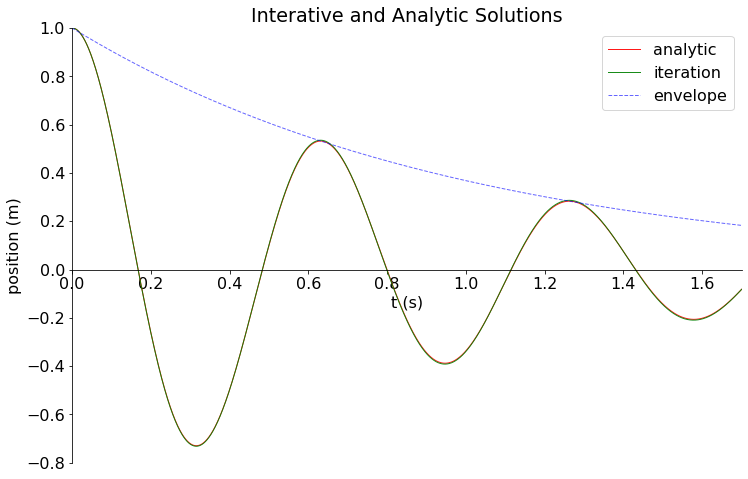

In [7]:
fig2, ax2 = plt.subplots()

ax2.plot(modelTime, xposition,
         color = 'red', linestyle = '-',alpha = 0.9,
         linewidth = 1., label = "analytic")
ax2.plot(iterationTime, xPos,
         color = 'green', linestyle = '-',alpha = 0.9,
         linewidth = 1., label = "iteration")
ax2.plot(modelTime, xenvelope,
         color = 'blue', linestyle = '--',alpha = 0.6,
         linewidth = 1., label = "envelope")


plt.rcParams.update({'font.size': 16}) # make labels easier to read
ax2.set(xlabel='t (s)', ylabel='position (m)',
       title='Interative and Analytic Solutions')

# set axes through 0,0
ax2.spines['left'].set_position(('data', 0))
ax2.spines['bottom'].set_position(('data', 0))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.xlim([0, 1.7])
plt.ylim([-.8, 1.])
fig2.set_size_inches(12, 8)
plt.legend(loc= 1)

plt.savefig("images/damped.jpg")
plt.show()

### Now that it works?

Sometimes this process I just went through is called testing a 'toy model'. The idea that we need to make sure that the calculation we are doing gives us the correct answer to a known problem. After that we can go forward and try it out on calculations where it's unclear what the result would be. 

### True Air Drag:

True air drag depends on the square of the velocity which leads to the following DE which is [not easily solved analytically](https://math.stackexchange.com/questions/2166648/second-order-non-linear-differential-equation-airdrag). 

$$ \large \frac{d^2x}{dt^2} + \frac{D}{m}(\frac{dx}{dt})^2 + \frac{k}{m} x = 0 $$

On the other hand our numerical technique should be able to handle it just fine. It turns out to be a little more complex since $v^2$ loses the information about the direction of the velocity and hence the impact on the acceleration. I am out of time and that will have to wait for another day.